In [230]:
# Downloading PDFs
import requests
from bs4 import BeautifulSoup
import wget

# Data handling
import pandas as pd
import numpy as np
import datetime
import re

# Statistics
import statsmodels.tsa.x13 as sx13

# I/O
import os

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
%matplotlib inline

# Misc
import itertools

In [3]:
# set directory for files to be stored
DIR = "Data"
os.chdir(DIR)

### Reading and organizing data

In [24]:
''' Read in all tax data
Columns:
period - indicates yaer and quarter in format (YYYY Q[1-4])
original - non-seasonally adjusted value
adjusted - seasonally adjusted value*
state - indicates state with postal abbreviation. US denotes the total of all states except the District of Columbia.
category - indicates type of tax. Types included are:
    - Property 
    - General Sales and Gross Receipts 
    - Alcoholic Beverages Sales 
    - Amusements Sales 
    - Insurance Premiums Sales 
    - Motor Fuels Sales 
    - Pari-Mutuels Sales 
    - Public Utilities Sales 
    - Tobacco Products Sales 
    - Other Selective Sales and Gross Receipts 
    - Alcoholic Beverages License
    - Amusements License
    - Corporations in General License
    - Hunting and Fishing License
    - Motor Vehicles License
    - Motor Vehicles Operators License
    - Public Utilities License
    - Occupation and Business License
    - Other License 
    - Individual Income 
    - Corporation Net Income 
    - Death and Gift 
    - Documentary and Stock Transfer 
    - Severance 
    - Other Not Elsewhere Classified
    - Total 
    See dataset documentation for detail on category definitions.
    
*seasonally adjusted values obtained with X-13 SEATS procedure run with RJDMetra package in R. Used 
JDMetra 'RSA2c' preset specs: auto multiplicative/additive model detection; auto additive/level shift/temporary outlier detection;
trading day and Easter calendar effects (thinking was that they would affect sales/stock transfer/and possibly license taxes);
and the (0,1,1)(0,1,1) ARIMA model. 
'''

# Note: I did some initial data cleanup (e.g. renaming columns, deleting unneccessary columns, INDEX/MATCH-ing numerical keys
# with their corresponding English language values for ease of reference) in Excel. When I have some time I'll automate the
# data cleaning in pandas so new quarters can be added quickly.

file_path = "QTAX_adj.csv"
qtax_full = pd.read_csv(file_path, header = 0,parse_dates = [0])

In [217]:
# Work in progress
#class QTax_Data():
    #def __init__(self, data = qtax_full):
        #self.data = data
        #self.totals


# Dict to reference dataframes by state names for easy file reading/writing
top_15_totals = {"california":'',
                 "texas":'',
                 "newyork":'',
                 "florida":'',
                 "pennsylvania":'',
                "illinois":'',
                 "ohio":'',
                 "georgia":'',
                 "northcarolina":'',
                 #"michigan":'', -- removing michigan because data appears to retain noticeable seasonality
                 # even after adjustment
                 "newjersey":'',
                 "virginia":'',
                "washington":'',
                 "arizona":'',
                 "massachusetts":''}
# State abbreviation dict to make switching between full name / abbr easier
state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    'United States':'US'
}

south = ['AL','GA','VA','KY','TN','TX','FL','LA','MS','MO','KS','SC','NC']
west_coast = ['CA','WA','OR']
east_coast = ['FL','GA','NC','SC','MD','NJ','NY','MA','CT','ME']
coast = west_coast.append(east_coast)
south_west = ['AZ','AR','CO','TX','NV','NM']
has_major_city = ['CA','WA','PA','NY','IL','TX','FL','NV','GA']
def abbrev(state):
    try:
        return us_state_abbrev[state]
    except:
        return state
    
by_state_data = {}
for state in state_abbrev:
    by_state_data[state] = qtax_full[qtax_full.state == abbrev(state)].pivot("period","category",
                                                                             ["original","adjusted"])
    by_state_data[state].index = by_state_data[state].index.to_period(freq = "Q")
    #for column in by_state_data[state].columns.levels[1]:
    #by_state_data[state]["adjusted"].pct_change())
        #by_state_data[state]["y_pct_change",column] = by_state_data[state]["original",column].pct_change(periods = 4) 


In [213]:
new = by_state_data["Virginia"]["adjusted"].pct_change()

#pd.concat([by_state_data["Virginia"],new],axis = 1,keys = ["original","adjusted","q_pct_change"])
new1 = by_state_data["Virginia"].join(new.rename(columns = {"adjusted":"q_pct_change"}))

In [216]:
new.columns

Index(['Alcoholic Beverages License', 'Alcoholic Beverages Sales',
       'Corporation Net Income', 'Corporations in General License',
       'Death and Gift', 'Documentary and Stock Transfer',
       'General Sales and Gross Receipts', 'Hunting and Fishing License',
       'Individual Income', 'Insurance Premiums Sales', 'Motor Fuels Sales',
       'Motor Vehicles License', 'Motor Vehicles Operators License',
       'Occupation and Business License', 'Other License',
       'Other Not Elsewhere Classified',
       'Other Selective Sales and Gross Receipts', 'Property',
       'Public Utilities Sales', 'Severance', 'Tobacco Products Sales',
       'Total'],
      dtype='object', name='category')

In [30]:
#def read_adj(state,cat = "total"):
    #return pd.read_csv("{}_{}_adj.csv".format(state,cat), header = 0,
                       #parse_dates = [0], infer_datetime_format = True)

#for key in top_15_totals:
    #top_15_totals[key] = read_adj(key)
    #top_15_totals[key].time = top_15_totals[key].time.str.replace(":","-Q")
    

In [31]:
# Add state column, quarterly percent change and yearly percent change, combine into single data frame for 
# graphing
top_15_total = pd.DataFrame(columns = ["period","original","adjusted","state","q_pct_change","y_pct_change"])
for key in top_15_totals:
    top_15_totals[key]["state"] = abbr_lookup[key]
    top_15_totals[key]["q_pct_change"] = top_15_totals[key]["adjusted"].pct_change()
    top_15_totals[key]["y_pct_change"] = top_15_totals[key]["original"].pct_change(periods = 4) # using original non- adjusted vals for y-y change
    top_15_total = top_15_total.append(top_15_totals[key])

In [20]:
top_15_total_val = top_15_total.pivot("time", "state", "adjusted")
top_15_total_val.index = top_15_total_val.index.to_period(freq = "Q")

state,AZ,CA,FL,GA,IL,MA,NC,NJ,NY,OH,PA,TX,VA,WA
time,,,,,,,,,,,,,,
1994Q1,1488.249300,12613.979470,4445.354218,7615.540557,3689.268742,2760.811653,2603.902221,3722.371662,7615.540557,3522.164592,4393.560012,4362.159343,2035.446552,2651.111533
1994Q2,1516.326939,12157.203282,4537.776543,8968.645367,3829.658009,2732.888595,2761.257375,3648.518930,8968.645367,3565.962385,4364.161531,4435.308401,2064.063556,2190.203248
1994Q3,1484.169233,12957.370181,4542.449951,8372.165640,3967.247159,2832.813156,2748.823759,3535.214393,8372.165640,3536.463251,4443.375192,4504.767216,2081.564086,2558.546475
1994Q4,1527.552185,12801.546181,4583.086786,8411.323701,3945.200604,2797.343610,2789.291170,3493.986376,8411.323701,3641.822544,4567.621457,4630.306493,2107.155417,2556.616809
1995Q1,1525.796998,13343.911683,4676.449616,7569.656637,4033.559887,3067.893918,2940.285389,3433.030217,7569.656637,3513.880094,4594.366604,4609.042689,2128.700272,2515.746804


## Total revenue heatmaps 

/Users/becca/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


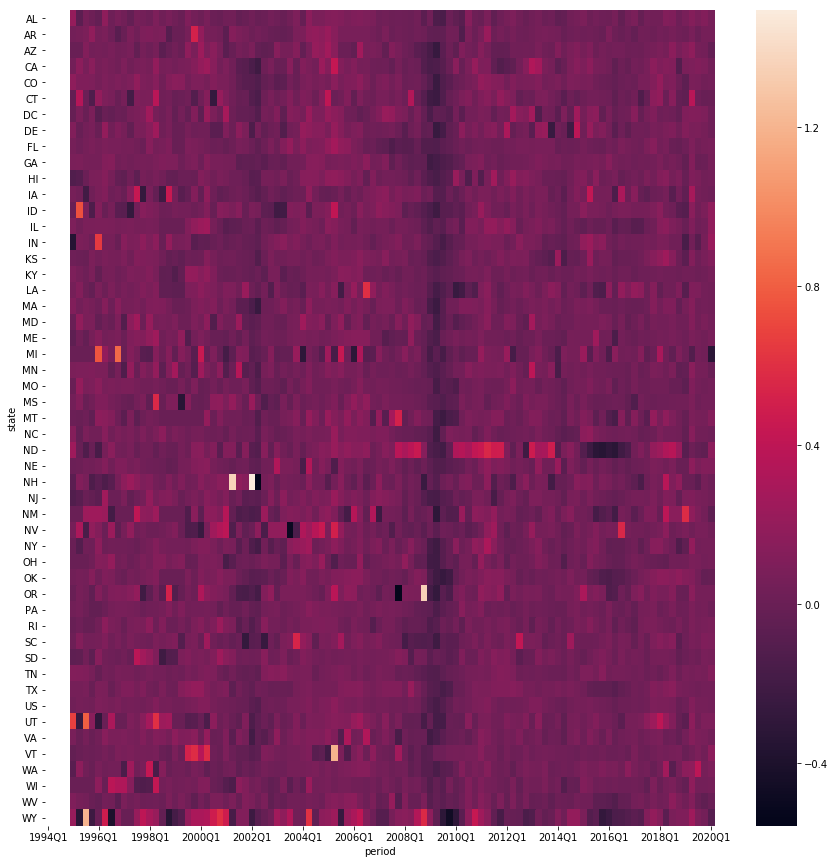

In [47]:
fig,ax = plt.subplots(figsize=(15,15))
totals_yoy = qtax_full[qtax_full.category == "Total"][qtax_full.state != "AK"].pivot("period","state","original")
totals_yoy.index = totals_yoy.index.to_period(freq = "Q")
for column in totals_yoy.columns:
    totals_yoy[column] = totals_yoy[column].pct_change(periods = 4)
sns.heatmap(totals_yoy.transpose(),ax = ax,xticklabels = 8)

/Users/becca/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


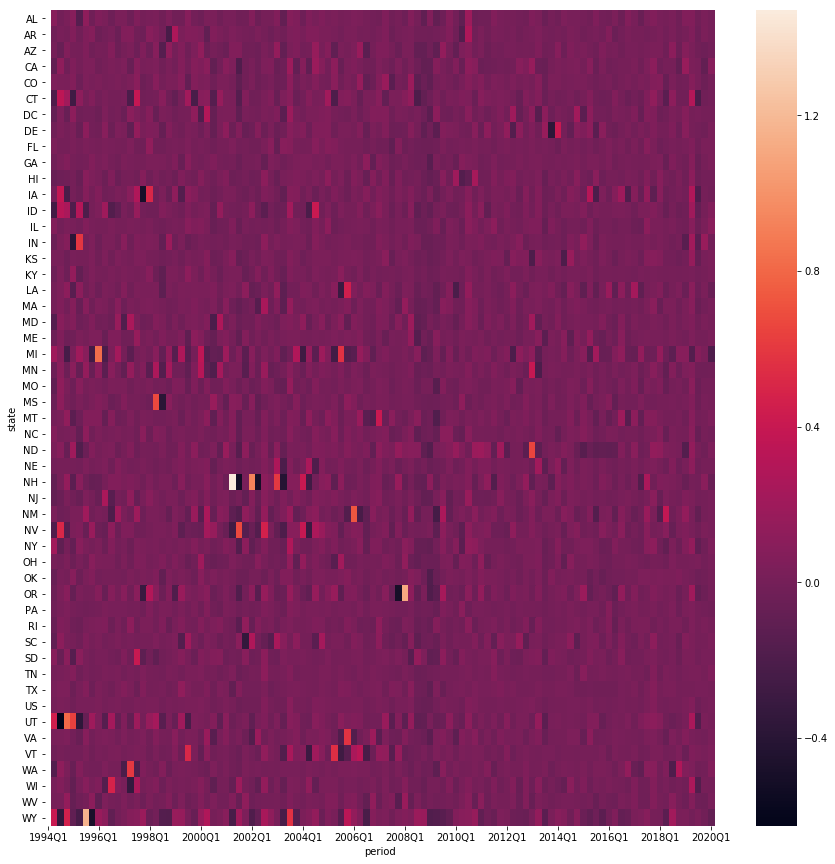

In [48]:
fig,ax = plt.subplots(figsize=(15,15))
totals_qoq = qtax_full[qtax_full.category == "Total"][qtax_full.state != "AK"].pivot("period","state","adjusted")
totals_qoq.index = totals_qoq.index.to_period(freq = "Q")
for column in totals_qoq.columns:
    totals_qoq[column] = totals_qoq[column].pct_change()
sns.heatmap(totals_qoq.transpose(),ax = ax,xticklabels = 8)

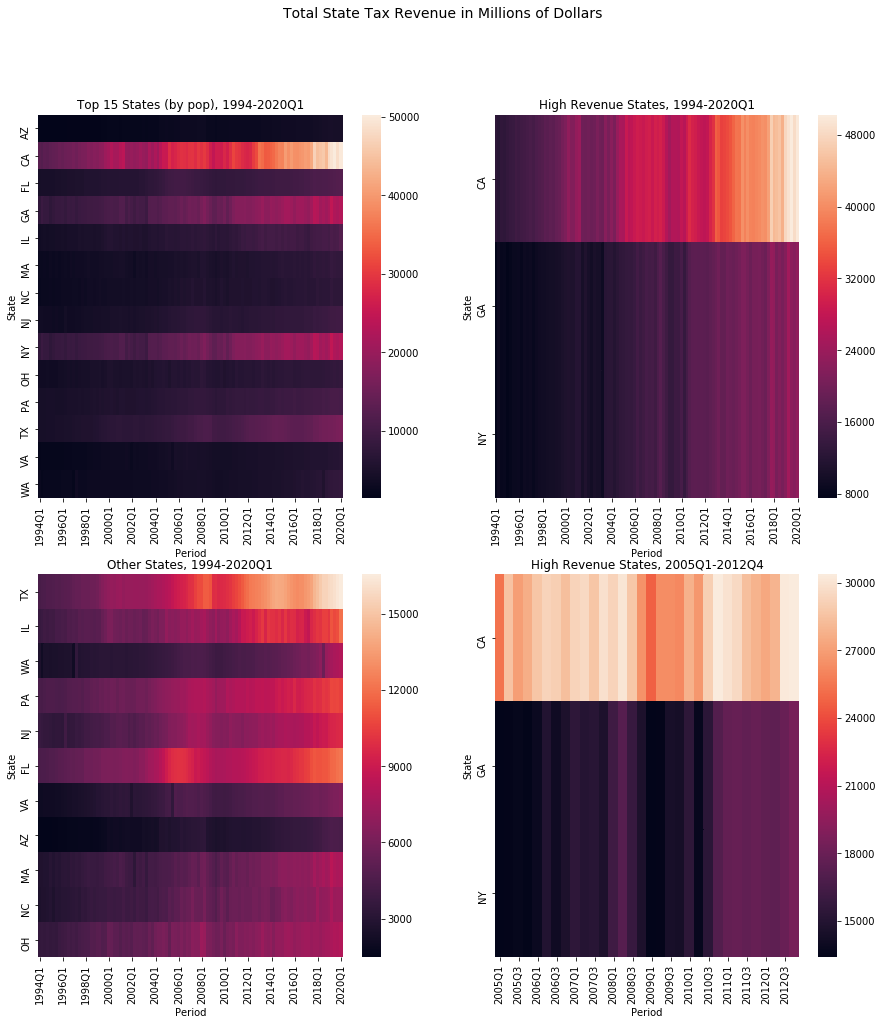

In [32]:
fig, axs = plt.subplots(2,2, figsize=(15,15))
ul = axs[0,0]
ur = axs[0,1]
ll = axs[1,0]
lr = axs[1,1]

sns.heatmap(top_15_total_val.transpose(),ax = ul,xticklabels = 8)
ul.set_ylabel("State")
ul.set_xlabel("Period")
ul.set_title("Top 15 States (by pop), 1994-2020Q1")
plt.subplots_adjust(bottom=.1)

# Isolate high revenue states
high_rev_states = ["CA","GA","NY"]
sns.heatmap(top_15_total_val[high_rev_states].transpose(),ax = ur,xticklabels = 8)
ur.set_ylabel("State")
ur.set_xlabel("Period")
ur.set_title("High Revenue States, 1994-2020Q1")

# Other states
other_states = list(set(top_15_total_val.columns) - set(high_rev_states))
sns.heatmap(top_15_total_val[other_states].transpose(),ax = ll,xticklabels = 8)
ll.set_ylabel("State")
ll.set_xlabel("Period")
ll.set_title("Other States, 1994-2020Q1")

# Zoom in on 2005-2012
sns.heatmap(top_15_total_val.loc[pd.Period('2005Q1'):pd.Period('2012Q4'),:][high_rev_states].transpose(),
            ax = lr,xticklabels = 2,robust = True)
lr.set_ylabel("State")
lr.set_xlabel("Period")
lr.set_title("High Revenue States, 2005Q1-2012Q4")
fig.suptitle("Total State Tax Revenue in Millions of Dollars",fontsize=14)
plt.show()

In [191]:
# Graph quarterly and yearly percent change
top_15_total_qchange = top_15_total.pivot("time", "state", "q_pct_change")
top_15_total_qchange.index = top_15_total_qchange.index.to_period(freq = "Q")
top_15_total_ychange = top_15_total.pivot("time", "state", "y_pct_change")
top_15_total_ychange.index = top_15_total_ychange.index.to_period(freq = "Q")

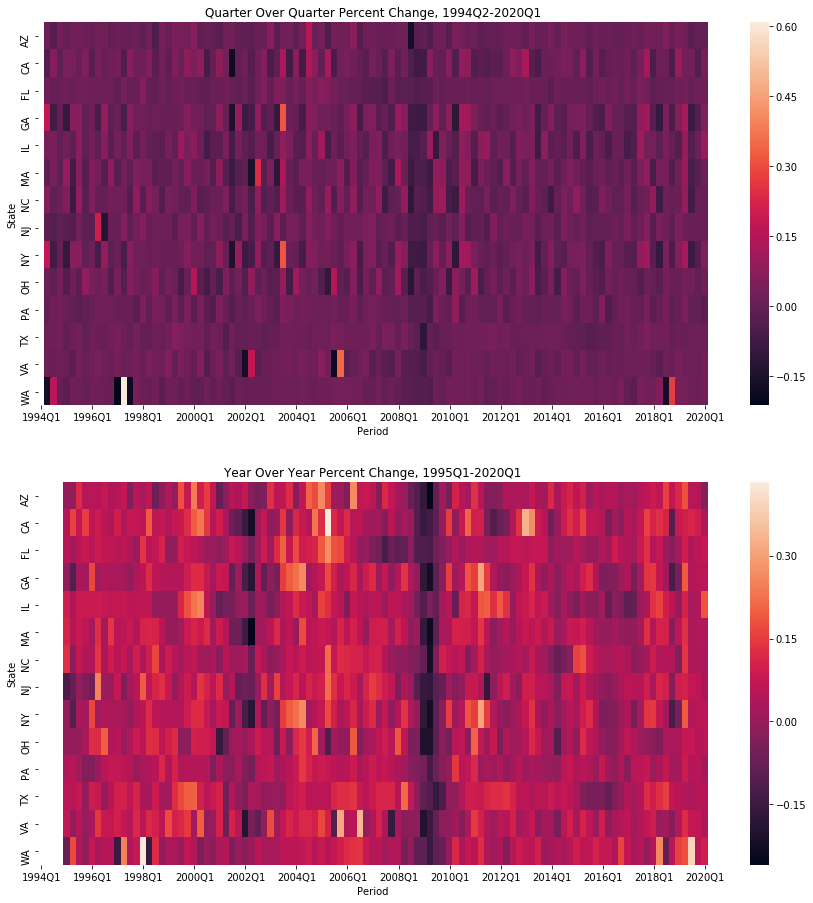

In [189]:
fig, (ax0,ax1) = plt.subplots(2,1,figsize=(15,15))
sns.heatmap(top_15_total_qchange.transpose(),ax = ax0,xticklabels = 8)
ax0.set_ylabel("State")
ax0.set_xlabel("Period")
ax0.set_title("Quarter Over Quarter Percent Change, 1994Q2-2020Q1")
plt.subplots_adjust(bottom=.1)
sns.heatmap(top_15_total_ychange.transpose(),ax = ax1,xticklabels = 8)
ax1.set_ylabel("State")
ax1.set_xlabel("Period")
ax1.set_title("Year Over Year Percent Change, 1995Q1-2020Q1")
plt.subplots_adjust(bottom=.1)

Notes:
* Outlier in Washington state during 1997, anomalous dip and spike. Attributable to volatile general
   sales and use taxes. Rate increases were approved in metro area for football stadium construction and new transi      system, also internet boom contributed to large sales tax increase.
* Outlier in California in 2005
* Florida revenue smoothest through recession (though decline begins earlier)
* States with severe dips in 2001-2002 also have severe dips in 2008-2009.

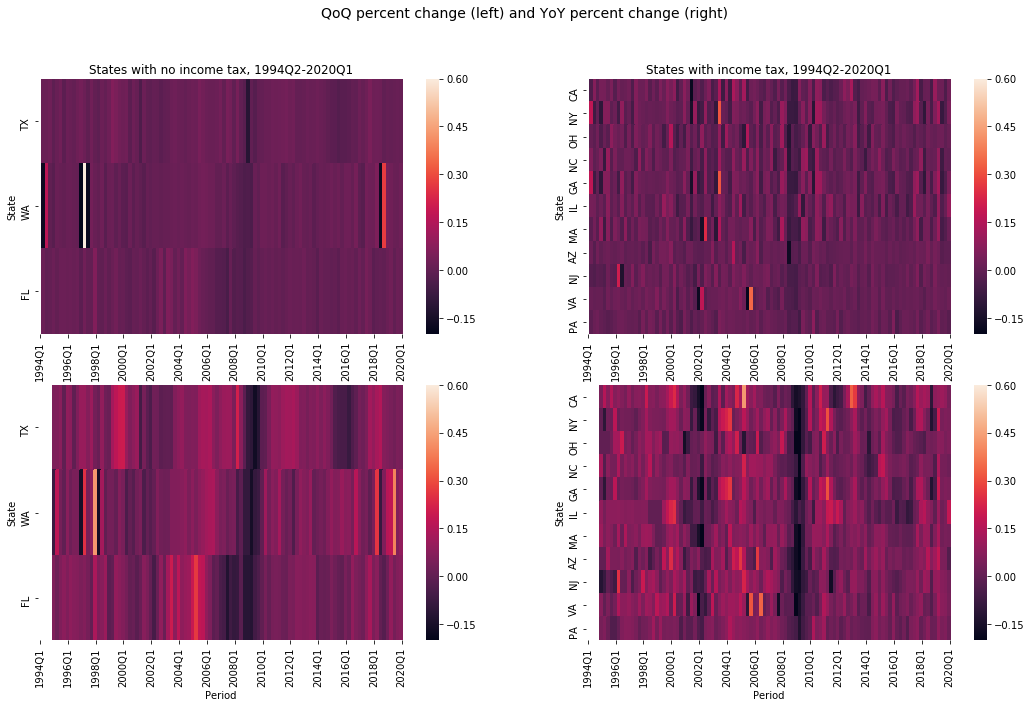

In [248]:
# Comparing states without income tax (FL, TX, WA) to states with income tax
no_income_tax = ['TX','WA','FL']
income_tax = list(set(top_15_total_qchange.columns) - set(no_income_tax))
min_ = -.2
max_ = .6
fig, axs = plt.subplots(2,2, figsize=(18,10))
ul = axs[0,0]
ur = axs[0,1]
ll = axs[1,0]
lr = axs[1,1]

sns.heatmap(top_15_total_qchange[no_income_tax].transpose(),ax = ul,xticklabels = 8, vmin = min_, vmax = max_)
ul.set_ylabel("State")
ul.set_xlabel("Period")
ul.set_title("States with no income tax, 1994Q2-2020Q1")
plt.subplots_adjust(bottom=.1)

sns.heatmap(top_15_total_qchange[income_tax].transpose(),ax = ur,xticklabels = 8,vmin = min_, vmax = max_)
ur.set_ylabel("State")
ur.set_xlabel("Period")
ur.set_title("States with income tax, 1994Q2-2020Q1")

sns.heatmap(top_15_total_ychange[no_income_tax].transpose(),ax = ll,xticklabels = 8,vmin = min_, vmax = max_)
ll.set_ylabel("State")
ll.set_xlabel("Period")

# Zoom in on 2005-2012
sns.heatmap(top_15_total_ychange[income_tax].transpose(),
            ax = lr,xticklabels = 8,vmin = min_, vmax = max_)
lr.set_ylabel("State")
lr.set_xlabel("Period")
fig.suptitle("QoQ percent change (top) and YoY percent change (bottom)",fontsize=14)
plt.show()

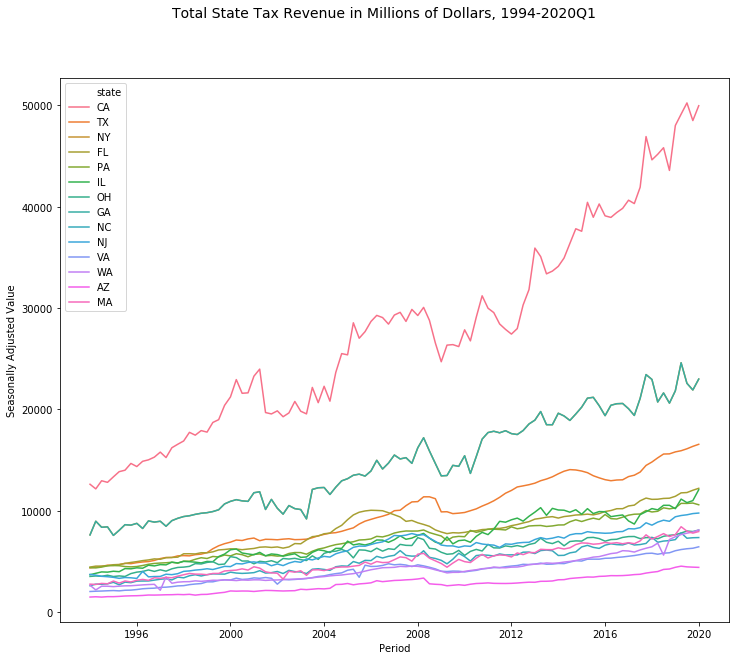

In [254]:
# Line plots
fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x = "time", y = "adjusted", data = top_15_total, hue = "state")
ax.set_xlabel("Period")
ax.set_ylabel("Seasonally Adjusted Value")
fig.suptitle("Total State Tax Revenue in Millions of Dollars, 1994-2020Q1",fontsize=14)
plt.show()

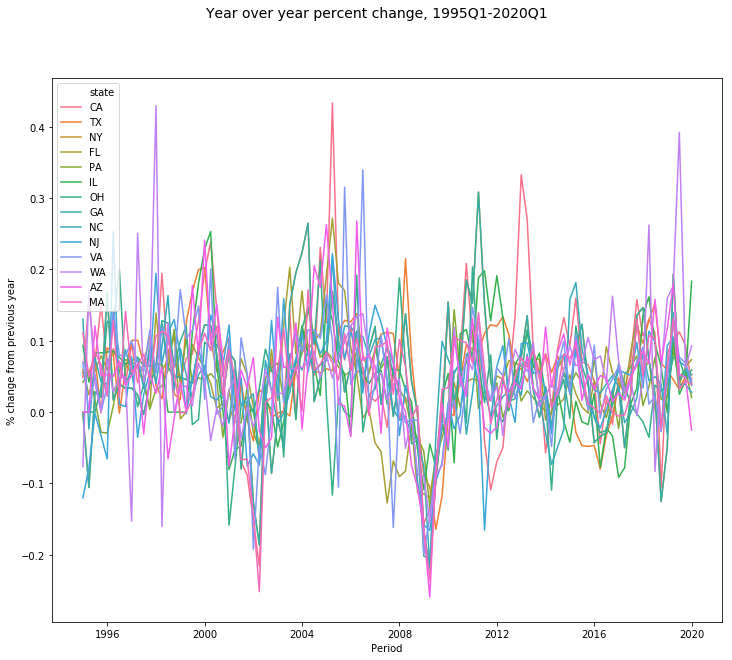

In [258]:
fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x = "time", y = "y_pct_change", data = top_15_total, hue = "state")
ax.set_xlabel("Period")
ax.set_ylabel("% change from previous year")
ax.legend(loc=2)
fig.suptitle("Year over year percent change, 1995Q1-2020Q1",fontsize=14)
plt.show()

In [267]:
# Add some unemployment data (from FRED via BLS)

unemployment = pd.read_csv("Data/Unemployment/state_unemployment.txt", sep = "\t",header = 0, parse_dates = [0])

In [268]:
unemployment.head()

,DATE,AZ,CA,FL
0,2003-10-01,9.9,11.7,9.3
1,2004-01-01,9.7,11.6,9.1
2,2004-04-01,9.6,11.4,9.0
3,2004-07-01,9.1,11.2,8.6
4,2004-10-01,9.2,11.0,8.3


In [ ]:
# June 23 - July 1 To-Do
# go through annual survey for state / local revenue breakdown. Which states are more self sufficient versus which 
# dependent on particular localities. Some volatility because most stuff at local level. 
# What does local revenue look like. Which parts are more cyclical, less cyclical? Impute from annual survey about local 
# tax revenue. 
# Look at cyclical patterns with localities and states. Probably ok at annual level, need quarterly updating process
# Want to quickly anticipate revenue, on a quarterly basis
# LAUS unemployment statistics from FRED (State abbrev + UR)
# FRED payroll unemployment data

In [169]:
"""Import local and state annual survey data
Source: U.S. Census Bureau, Annual Survey of State and Local Government Finances and Census of Governments (1977-2017) 
via the State and Local Finance Data Query System, Urban-Brookings Tax Policy Center

2001 and 2003 missing because sample design during those years only allowed national level estimates. 
"""
columns = ["State", 
          "Year",
          "TotalTaxes",
          "Property",
           "NonProperty",
           "SalesAndGrossReceipts",
           "GeneralSales",
           "SelectSales",
           "AlcoholicBeverageSales",
           "AmusementsSales",
           "InsurancePremiumSales",
           "MotorFuelsSales",
           "ParimutuelsSales",
           "PublicUtilitySales",
           "TobaccoSales",
           "OtherSelectSales",
           "TotalLicense",
           "AlcoholicBeverageLicense",
           "CorporationLicense",
           "MotorVehicleAndOperatorLicense",
           "MotorVehicleLicense",
           "MotorVehicleOperatorLicense",
           "OtherLicnese",
           "TotalIncome",
           "IndividualIncome",
           "CorporateNetIncome",
           "Death and Gift Tax",
           "NEC"
          ]

local_annual_survey = pd.read_csv("Annual Surveys/local_annual_survey.csv",skiprows = 3, names = columns, parse_dates = [1])
combined_annual_survey = pd.read_csv("Annual Surveys/combined_annual_survey.csv",skiprows = 3,
                                     names = columns, parse_dates = [1])
#combined_annual_survey.dropna(axis=0,inplace = True)
for df in [local_annual_survey,combined_annual_survey]:
    df.drop("NEC", axis = 1, inplace = True)
    df.dropna(axis = 0, inplace = True)
    df[df.columns[2:]] = df[df.columns[2:]].apply(lambda x: x.str.replace("$",""))
    df[df.columns[2:]] = df[df.columns[2:]].apply(lambda x: x.str.replace(",","")).astype(float)
    df[df.columns[2:]] = df[df.columns[2:]].apply(lambda x: x/1000)
    df['State'] = df['State'].apply(lambda x: abbrev(x))

In [221]:
# Percent of total state tax revenue from local tax revenue
local_totals = local_annual_survey.pivot("Year","State","TotalTaxes")
combined_totals = combined_annual_survey.pivot("Year","State","TotalTaxes")
percent_local = local_totals.div(combined_totals)
percent_local.drop(["US","DC"],axis=1,inplace = True)
percent_local.interpolate(method = "linear",inplace = True)
#percent_local.reset_index(inplace = True)

In [153]:
#percent_local = percent_local.melt("Year")

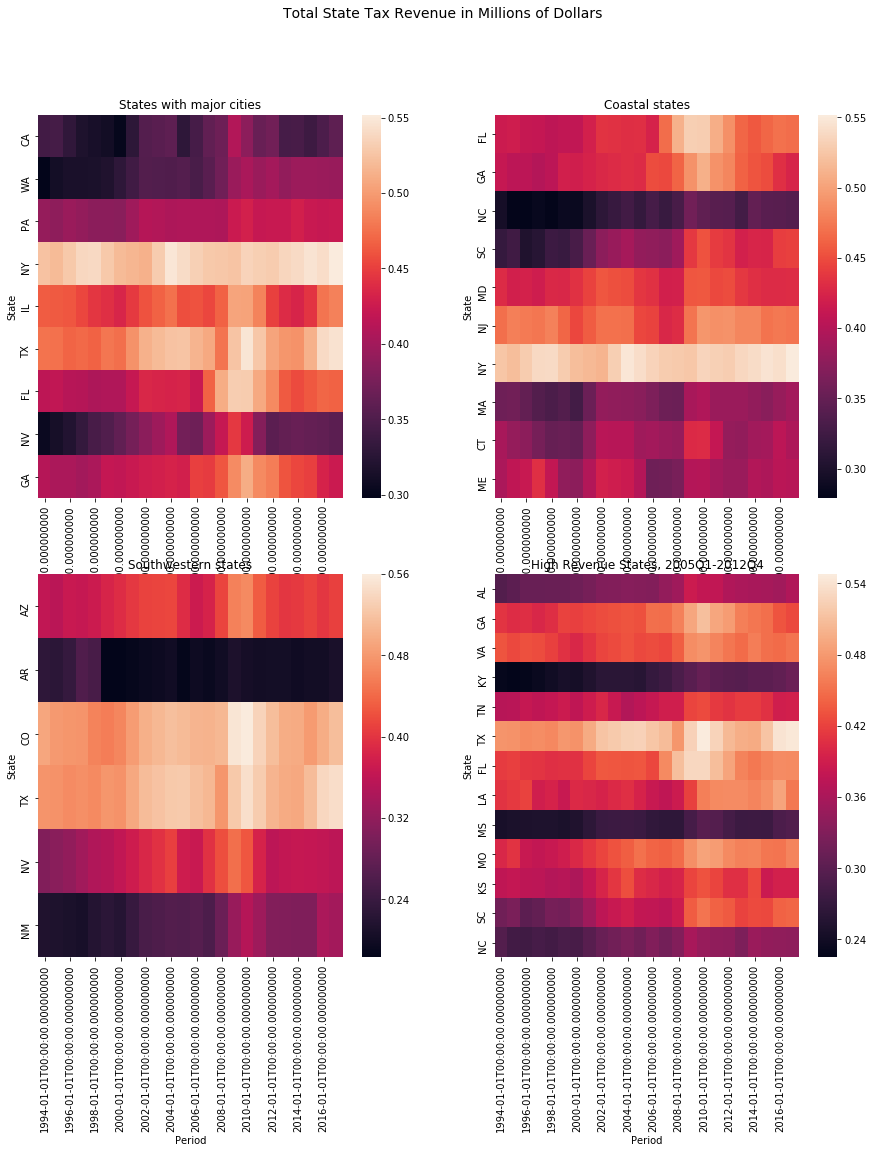

In [237]:
fig, axs = plt.subplots(2,2, figsize=(15,15))
ul = axs[0,0]
ur = axs[0,1]
ll = axs[1,0]
lr = axs[1,1]
date_format = DateFormatter('%Y')

#states with major cities
sns.heatmap(percent_local[has_major_city].transpose(),ax = ul,xticklabels = 2)
ul.set_ylabel("State")
ul.set_xlabel("Period")
ul.set_title("States with major cities")
#ul.xaxis_date()
#ul.xaxis.set_major_formatter(date_format)
plt.subplots_adjust(bottom=.1)

# east coast states
sns.heatmap(percent_local[east_coast].transpose(),ax = ur,xticklabels = 2)
ur.set_ylabel("State")
ur.set_xlabel("Period")
ur.set_title("Coastal states")

# southwestern states
sns.heatmap(percent_local[south_west].transpose(),ax = ll,xticklabels = 2)
ll.set_ylabel("State")
ll.set_xlabel("Period")
ll.set_title("Southwestern states")

# S=southern states
sns.heatmap(percent_local[south].transpose(),
            ax = lr,xticklabels = 2)
lr.set_ylabel("State")
lr.set_xlabel("Period")
lr.set_title("High Revenue States, 2005Q1-2012Q4")
fig.suptitle("Total State Tax Revenue in Millions of Dollars",fontsize=14)
plt.show()